In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math, copy
from extra_files.lab_utils_uni import plt_intuition, plt_stationary, plt_update_onclick, soup_bowl

## Training a simple linear regression model with `multiple variables`

### The model's prediction with multiple variables is given by the linear model:

$$ f_{\mathbf{w},b}(\mathbf{x}) =  w_0x_0 + w_1x_1 +... + w_{n-1}x_{n-1} + b \tag{1}$$
or in vector notation:
$$ f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b  \tag{2} $$

## Data Loading

In [3]:
trainDF = pd.read_csv('../../data/house_prices/train.csv')
trainDF.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
year_built_column = trainDF['YearBuilt']
lot_area_column = trainDF['LotArea']
year_sold_column = trainDF['YrSold']
lot_frontage_column = trainDF['LotFrontage']

# x_train is the input matrix that contains each vector of data
x_train = np.column_stack((year_built_column, lot_area_column, year_sold_column, lot_frontage_column))

# y_train is the target (price in 1000s of dollars)
y_train = np.array(trainDF['SalePrice'])

In [7]:
# data is stored in numpy array/matrix
print(f"x Shape: {x_train.shape}, x Type:{type(x_train)})")
print(f"x_train = {x_train}")
print(f"\ny Shape: {y_train.shape}, y Type:{type(y_train)})")
print(f"y_train = {y_train}")

x Shape: (1460, 4), x Type:<class 'numpy.ndarray'>)
x_train = [[ 2003.  8450.  2008.    65.]
 [ 1976.  9600.  2007.    80.]
 [ 2001. 11250.  2008.    68.]
 ...
 [ 1941.  9042.  2010.    66.]
 [ 1950.  9717.  2010.    68.]
 [ 1965.  9937.  2008.    75.]]

y Shape: (1460,), y Type:<class 'numpy.ndarray'>)
y_train = [208500 181500 223500 ... 266500 142125 147500]


## Computing model's function output

In [10]:
def predict(x, w, b): 
    """
    single predict using linear regression
    Args:
      x (ndarray): Shape (n,) example with multiple features
      w (ndarray): Shape (n,) model parameters   
      b (scalar):             model parameter 
      
    Returns:
      p (scalar):  prediction
    """
    p = np.dot(x, w) + b     
    return p    

In [17]:
w_init = np.zeros(len(x_train[0]))
b_init = 100

In [19]:
# get a row from our training data
x_vec = x_train[0,:]
print(f"x_vec shape {x_vec.shape}, x_vec value: {x_vec}")

# make a prediction
prediction = predict(x_vec,w_init, b_init)
print(f"prediction shape {prediction.shape}, prediction: {prediction}")

x_vec shape (4,), x_vec value: [2003. 8450. 2008.   65.]
prediction shape (), prediction: 100.0


## Computing cost

### `Squared error` cost function

The equation for `Squared error` cost function with `multiple variables` $J(\mathbf{w},b)$ is:
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{3}$$ 
where $\mathbf{w}$ and $\mathbf{x}^{(i)}$ are vectors:
$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b  \tag{4} $$ 




In [21]:
def compute_cost(X, y, w, b): 
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):                                
        f_wb_i = np.dot(X[i], w) + b           #(n,)(n,) = scalar (see np.dot)
        cost = cost + (f_wb_i - y[i])**2       #scalar
    cost = cost / (2 * m)                      #scalar    
    return cost

In [22]:
# Compute and display cost using our pre-chosen optimal parameters. 
cost = compute_cost(x_train, y_train, w_init, b_init)
print(f'Cost at optimal w : {cost}')

Cost at optimal w : nan


## Gradient descent

### `Computing gradients`

### - We first need to take the `partial derivatives` of this function in respsects to `w` & `b`
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{3}$$ 

### - That gives us
$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{6}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{7}
\end{align}
$$

In [31]:
def compute_gradient(X, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape           #(number of examples, number of features)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):                             
        err = (np.dot(X[i], w) + b) - y[i]   
        for j in range(n):                         
            dj_dw[j] = dj_dw[j] + err * X[i, j]    
        dj_db = dj_db + err                        
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m                                
        
    return dj_db, dj_dw

In [32]:
#Compute and display gradient 
tmp_dj_db, tmp_dj_dw = compute_gradient(x_train, y_train, w_init, b_init)
print(f'dj_db at initial w,b: {tmp_dj_db}')
print(f'dj_dw at initial w,b: \n {tmp_dj_dw}')

dj_db at initial w,b: nan
dj_dw at initial w,b: 
 [nan nan nan nan]


### Putting it all together: (1) `calculate gradients` (2) `update parameters` (3) `repeate until convergence`

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{5}  \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

In [33]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn w and b. Updates w and b by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
      """
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = gradient_function(X, y, w, b)   ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( cost_function(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}   ")
        
    return w, b, J_history #return final w,b and J history for graphing

### Running Gradient Descent

In [34]:
# initialize parameters
initial_w = np.zeros_like(w_init)
initial_b = 0.
# some gradient descent settings
iterations = 1000
alpha = 5.0e-7
# run gradient descent 
w_final, b_final, J_hist = gradient_descent(x_train, y_train, initial_w, initial_b,
                                                    compute_cost, compute_gradient, 
                                                    alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
m,_ = x_train.shape
for i in range(m):
    print(f"prediction: {np.dot(x_train[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")

Iteration    0: Cost      nan   
Iteration  100: Cost      nan   
Iteration  200: Cost      nan   
Iteration  300: Cost      nan   
Iteration  400: Cost      nan   
Iteration  500: Cost      nan   
Iteration  600: Cost      nan   
Iteration  700: Cost      nan   
Iteration  800: Cost      nan   
Iteration  900: Cost      nan   
b,w found by gradient descent: nan,[nan nan nan nan] 
prediction: nan, target value: 208500
prediction: nan, target value: 181500
prediction: nan, target value: 223500
prediction: nan, target value: 140000
prediction: nan, target value: 250000
prediction: nan, target value: 143000
prediction: nan, target value: 307000
prediction: nan, target value: 200000
prediction: nan, target value: 129900
prediction: nan, target value: 118000
prediction: nan, target value: 129500
prediction: nan, target value: 345000
prediction: nan, target value: 144000
prediction: nan, target value: 279500
prediction: nan, target value: 157000
prediction: nan, target value: 132000
predicti

## Evaluation

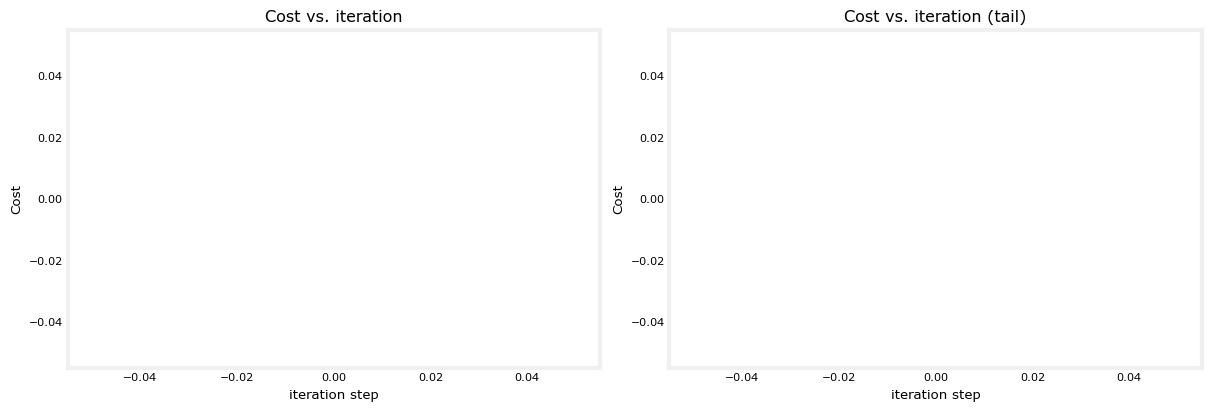

In [35]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(100 + np.arange(len(J_hist[100:])), J_hist[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()